### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Mendeley Dataset
(Source: https://data.mendeley.com/datasets/dzz48mvjht/1)

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("MendeleyData_75M25F_KNN_best_predictions.csv")

print(knn_df.head())

   gender  y_true    y_prob  y_pred
0       0       0  0.331268       0
1       1       0  0.000000       0
2       1       1  1.000000       1
3       1       1  1.000000       1
4       1       0  0.000000       0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["gender"].values

# Use gender_knn as the protected attribute (0/1 as in our CSV)
protected_attr_knn = gender_knn

print(
    "Shapes:",
    y_true_knn.shape,
    y_pred_knn.shape,
    y_prob_knn.shape,
    gender_knn.shape if gender_knn is not None else None
)
print("Example rows:\n", knn_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true    y_prob  y_pred
0       0       0  0.331268       0
1       1       0  0.000000       0
2       1       1  1.000000       1
3       1       1  1.000000       1
4       1       0  0.000000       0


In [5]:
# y_pred_knn already generated
# protected_attr = gender column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EPD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EPD - KNN
Demographic Parity Difference: 0.0802
Equalized Odds Difference: 0.1752


### Interpretation

- **Demographic Parity Difference (0.0802)**  
  - Shows a moderate disparity in the overall positive prediction rates between male and female groups.  
  - Since values closer to **0** indicate higher fairness, this result suggests **reasonable but not perfect parity**.  

- **Equalized Odds Difference (0.1752)**  
  - Captures a larger discrepancy in error rates (True Positive Rate and False Positive Rate) across genders.  
  - With a value of ~0.18, the KNN model **does not treat groups equally in terms of classification errors**, which highlights fairness concerns.  

---

**Overall**: While the KNN model achieves **acceptable demographic parity**, the elevated **equalized odds difference** indicates that prediction errors are **unevenly distributed between genders**, raising potential fairness issues in deployment.

In [6]:
# MetricFrame for extended analysis - define metrics
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.826087   0.909091  0.769231  0.833333        0.478261   
1                    0.961039   0.988372  0.944444  0.965909        0.558442   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.769231  0.100000  0.900000  0.230769  
1                    0.944444  0.015625  0.984375  0.055556  


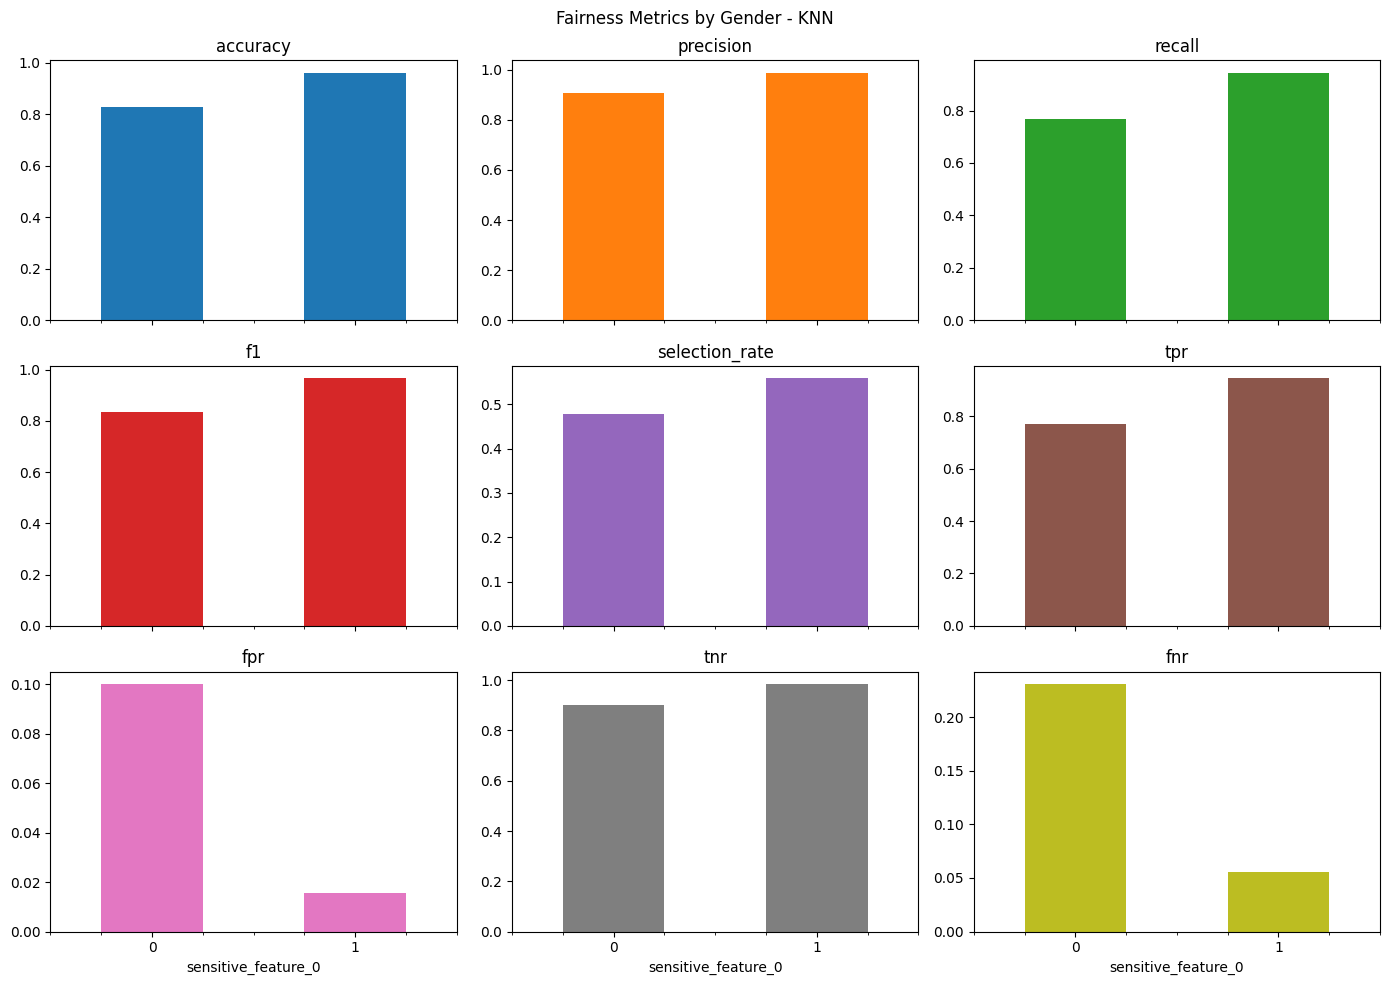


Between-group differences (max group − min group):
accuracy          0.134952
precision         0.079281
recall            0.175214
f1                0.132576
selection_rate    0.080181
tpr               0.175214
fpr               0.084375
tnr               0.084375
fnr               0.175214
dtype: float64

Between-group ratios (min / max):
accuracy          0.859577
precision         0.919786
recall            0.814480
f1                0.862745
selection_rate    0.856421
tpr               0.814480
fpr               0.156250
tnr               0.914286
fnr               0.240741
dtype: float64

Disparate Impact Ratio (selection rate): 0.8564
Equality of Opportunity Difference (TPR gap): 0.1752


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

## Fairness Metrics by Gender – KNN Model

This section summarizes the fairness evaluation of the KNN model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.8261   | 0.9091    | 0.7692 | 0.8333 | 0.4783         | 0.7692 | 0.1000 | 0.9000 | 0.2308 |
| Male    | 0.9610   | 0.9884    | 0.9444 | 0.9659 | 0.5584         | 0.9444 | 0.0156 | 0.9844 | 0.0556 |

---

### Between-Group Differences

| Metric           | Difference (max − min) | Ratio (min / max) |
|------------------|-------------------------|-------------------|
| Accuracy         | 0.1350                  | 0.8596            |
| Precision        | 0.0793                  | 0.9198            |
| Recall           | 0.1752                  | 0.8145            |
| F1               | 0.1326                  | 0.8627            |
| Selection Rate   | 0.0802                  | 0.8564            |
| TPR              | 0.1752                  | 0.8145            |
| FPR              | 0.0844                  | 0.1563            |
| TNR              | 0.0844                  | 0.9143            |
| FNR              | 0.1752                  | 0.2407            |

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate)**: **0.8564**  
  - Slightly above the 0.80 fairness threshold but still indicates **unequal opportunity in predictions**.  

- **Equality of Opportunity Difference (TPR gap)**: **0.1752**  
  - Males benefit from a **much higher true positive rate (94%)** compared to females (77%), revealing a **gender bias in sensitivity**.  

---

### Interpretation

- **Female group (0)** shows **weaker performance** across all metrics compared to males, especially in **recall and TPR**, where many positive cases are missed (FNR = 23%).  
- **Male group (1)** consistently achieves **higher accuracy, precision, recall, and F1**, along with a much lower false negative rate (6%).  
- The **selection rate disparity** (0.478 vs. 0.558) and fairness gaps confirm that **males are favored in prediction outcomes**, while females face higher misclassification risks.  

**Overall**: The KNN model demonstrates a **systematic gender bias**, providing **more favorable outcomes for males** and **less accurate, less fair predictions for females**, raising concerns about its equitable deployment in practice.

In [8]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN- Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.936538
1                    0.992188

KNN- Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.103607
1                    0.038008


## Group-Specific Performance – KNN Model

This section reports the ROC-AUC and Brier score for each gender group (0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9365  | 0.1036      |
| Male    | 0.9922  | 0.0380      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.94** – very good discrimination ability, but still notably lower than for males.  
  - Males: **0.99** – almost perfect discrimination, suggesting the model separates positive and negative cases much better for males.  

- **Brier Score**  
  - Females: **0.104** – higher error in probability calibration, meaning predicted probabilities are less reliable.  
  - Males: **0.038** – much lower error, indicating well-calibrated predictions for males.  

---

**Overall**: The KNN model provides **substantially better performance for males** in both discrimination (ROC-AUC) and calibration (Brier score). Females experience **weaker model reliability**, which highlights a **gender performance gap** that could translate into biased decision-making in practice.

---

### Bias detection for the Decision Tree Model

In [9]:
# Load DT results
dt_df = pd.read_csv("MendeleyData_75M25F_DT_tuned_predictions.csv")
print(dt_df.head())

   gender  y_true  y_pred_dt    y_prob
0       0       0          0  0.125000
1       1       0          0  0.125000
2       1       1          1  0.975845
3       1       1          1  0.849057
4       1       0          0  0.005236


In [10]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred_dt"].values
gender_dt = dt_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt

print(
    "Shapes:",
    y_true_dt.shape,
    y_pred_dt.shape,
    y_prob_dt.shape,
    gender_dt.shape if gender_dt is not None else None
)
print("Example rows:\n", dt_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred_dt    y_prob
0       0       0          0  0.125000
1       1       0          0  0.125000
2       1       1          1  0.975845
3       1       1          1  0.849057
4       1       0          0  0.005236


In [11]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.0387
Equalized Odds Difference: 0.0406


### Interpretation – Decision Tree Model

- **Demographic Parity Difference (0.0387)**  
  - Reflects a **small disparity** in the overall positive prediction rates between females and males.  
  - Since values close to **0** indicate fairness, this suggests the Decision Tree model achieves **near-parity** in selection outcomes.  

- **Equalized Odds Difference (0.0406)**  
  - Captures differences in error rates (TPR and FPR) across gender groups.  
  - With a value close to **0.04**, the gap is minimal, indicating the model **treats genders similarly in terms of classification errors**.  

---

**Overall**: The Decision Tree model demonstrates **strong fairness** across genders, with both demographic parity and equalized odds differences being very small. This implies **balanced prediction rates and error distributions**, with little evidence of gender bias.


DT Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.913043   0.923077  0.923077  0.923077        0.565217   
1                    0.902597   0.903226  0.933333  0.918033        0.603896   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.923077  0.100000  0.900000  0.076923  
1                    0.933333  0.140625  0.859375  0.066667  


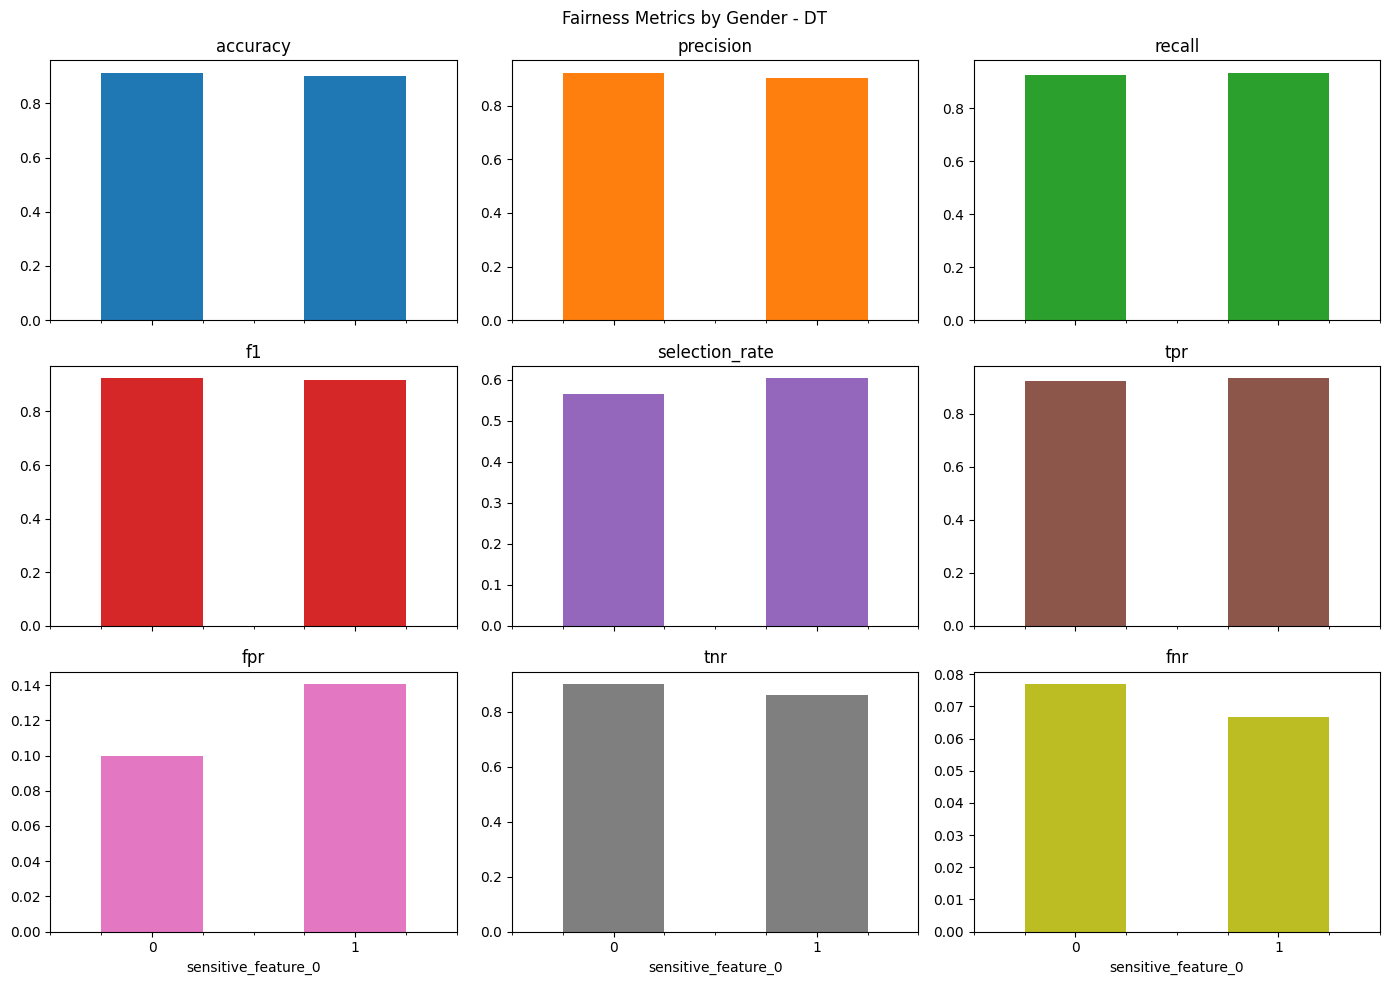


Between-group differences (max group − min group):
accuracy          0.010446
precision         0.019851
recall            0.010256
f1                0.005044
selection_rate    0.038679
tpr               0.010256
fpr               0.040625
tnr               0.040625
fnr               0.010256
dtype: float64

Between-group ratios (min / max):
accuracy          0.988559
precision         0.978495
recall            0.989011
f1                0.994536
selection_rate    0.935951
tpr               0.989011
fpr               0.711111
tnr               0.954861
fnr               0.866667
dtype: float64

Disparate Impact Ratio (selection rate): 0.9360
Equality of Opportunity Difference (TPR gap): 0.0103


In [12]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

## Fairness Metrics by Gender – Decision Tree Model

This section reports the fairness evaluation of the Decision Tree (DT) model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.9130   | 0.9231    | 0.9231 | 0.9231 | 0.5652         | 0.9231 | 0.1000 | 0.9000 | 0.0769 |
| Male    | 0.9026   | 0.9032    | 0.9333 | 0.9180 | 0.6039         | 0.9333 | 0.1406 | 0.8594 | 0.0667 |

---

### Between-Group Differences

| Metric           | Difference (max − min) | Ratio (min / max) |
|------------------|-------------------------|-------------------|
| Accuracy         | 0.0104                  | 0.9886            |
| Precision        | 0.0199                  | 0.9785            |
| Recall           | 0.0103                  | 0.9890            |
| F1               | 0.0050                  | 0.9945            |
| Selection Rate   | 0.0387                  | 0.9360            |
| TPR              | 0.0103                  | 0.9890            |
| FPR              | 0.0406                  | 0.7111            |
| TNR              | 0.0406                  | 0.9549            |
| FNR              | 0.0103                  | 0.8667            |

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate)**: **0.9360**  
  - Well above the **0.80 fairness threshold**, indicating that selection rates are relatively balanced across genders.  

- **Equality of Opportunity Difference (TPR gap)**: **0.0103**  
  - Very small gap between female (92.3%) and male (93.3%) true positive rates, suggesting **near-equal opportunity**.  

---

### Interpretation

- **Balanced Performance**: Accuracy, recall, and F1 scores are nearly identical for females and males, with only marginal differences.  
- **Slight Disparities**:  
  - Males have a slightly higher **recall/TPR**, but also a higher **false positive rate (14% vs. 10%)**, meaning they benefit from slightly more positive predictions but at the cost of more false alarms.  
  - Females receive slightly fewer positive predictions (lower selection rate), but with somewhat lower false positives.  
- **Fairness Assessment**: Both **disparate impact ratio** (~0.94) and **TPR gap** (~0.01) indicate **strong fairness**, with no major gender bias detected.  

**Overall**: The Decision Tree model demonstrates **highly balanced fairness across genders**, with only minor differences in error trade-offs (slightly more false positives for males). This makes it one of the more equitable models evaluated.

---

In [14]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.905769
1                    0.935156

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.086659
1                    0.082988


## Group-Specific Performance – Decision Tree Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9058  | 0.0867      |
| Male    | 0.9352  | 0.0830      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.91** – strong discrimination ability, but slightly lower than for males.  
  - Males: **0.94** – somewhat better discrimination, suggesting the model separates positive and negative cases marginally more effectively for males.  

- **Brier Score**  
  - Females: **0.087** – indicates good probability calibration, though with slightly higher error compared to males.  
  - Males: **0.083** – slightly better calibrated probabilities.  

---

**Overall**: The Decision Tree model shows **strong and fairly balanced performance** across genders. While males achieve **slightly higher ROC-AUC and better calibration**, the differences are **minor**, indicating that the model is **reasonably equitable in predictive reliability** for both groups.

---

### Bias detection for the Random Forest Model

In [15]:
rf_df = pd.read_csv("MendeleyData_75M25F_RF_tuned_predictions.csv")
print(rf_df.head())

   gender  y_true  y_pred_rf_tuned    y_prob
0       0       0                0  0.344558
1       1       0                0  0.010588
2       1       1                1  0.902502
3       1       1                1  0.937066
4       1       0                0  0.000000


In [16]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred_rf_tuned"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf

print(
    "Shapes:",
    y_true_rf.shape,
    y_pred_rf.shape,
    y_prob_rf.shape,
    gender_rf.shape if gender_dt is not None else None
)
print("Example rows:\n", rf_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred_rf_tuned    y_prob
0       0       0                0  0.344558
1       1       0                0  0.010588
2       1       1                1  0.902502
3       1       1                1  0.937066
4       1       0                0  0.000000


In [17]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.0438
Equalized Odds Difference: 0.0688


### Interpretation – Random Forest Model

- **Demographic Parity Difference (0.0438)**  
  - Indicates a **small disparity** in positive prediction rates between females and males.  
  - Since values closer to **0** represent greater fairness, this suggests the Random Forest achieves **near-parity in selection outcomes**.  

- **Equalized Odds Difference (0.0688)**  
  - Reflects a modest gap in error rates (TPR and FPR) between genders.  
  - With a value below **0.10**, the disparity is limited, implying the model **treats genders relatively similarly in classification errors**.  

---

**Overall**: The Random Forest model demonstrates **good fairness performance**, with only minor disparities across genders. Both demographic parity and equalized odds differences are small, suggesting that the model’s predictions are **largely balanced and equitable**.  


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.956522   0.928571  1.000000  0.962963        0.608696   
1                    0.954545   0.977011  0.944444  0.960452        0.564935   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    1.000000  0.10000  0.90000  0.000000  
1                    0.944444  0.03125  0.96875  0.055556  


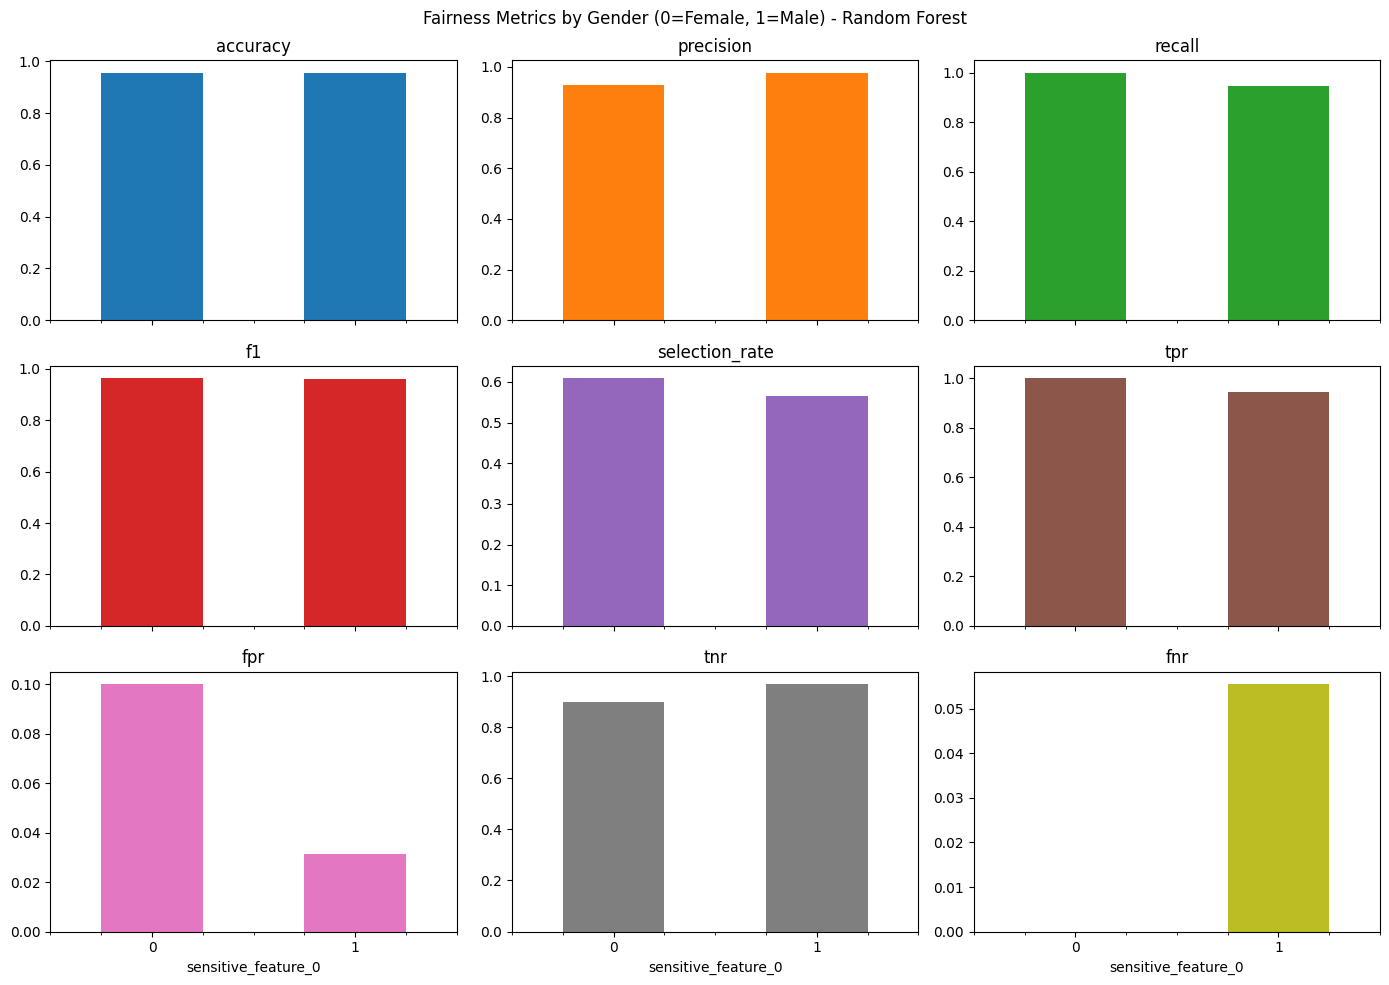


Between-group differences (max group − min group):
accuracy          0.001976
precision         0.048440
recall            0.055556
f1                0.002511
selection_rate    0.043761
tpr               0.055556
fpr               0.068750
tnr               0.068750
fnr               0.055556
dtype: float64

Between-group ratios (min / max):
accuracy          0.997934
precision         0.950420
recall            0.944444
f1                0.997392
selection_rate    0.928108
tpr               0.944444
fpr               0.312500
tnr               0.929032
fnr               0.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.9281
Equality of Opportunity Difference (TPR gap): 0.0556


In [18]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

## Fairness Metrics by Gender – Random Forest Model

This section reports the fairness evaluation of the Random Forest (RF) model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.9565   | 0.9286    | 1.0000 | 0.9630 | 0.6087         | 1.0000 | 0.1000 | 0.9000 | 0.0000 |
| Male    | 0.9545   | 0.9770    | 0.9444 | 0.9605 | 0.5649         | 0.9444 | 0.0313 | 0.9688 | 0.0556 |

---

### Between-Group Differences

| Metric           | Difference (max − min) | Ratio (min / max) |
|------------------|-------------------------|-------------------|
| Accuracy         | 0.0020                  | 0.9979            |
| Precision        | 0.0484                  | 0.9504            |
| Recall           | 0.0556                  | 0.9444            |
| F1               | 0.0025                  | 0.9974            |
| Selection Rate   | 0.0438                  | 0.9281            |
| TPR              | 0.0556                  | 0.9444            |
| FPR              | 0.0688                  | 0.3125            |
| TNR              | 0.0688                  | 0.9290            |
| FNR              | 0.0556                  | 0.0000            |

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate)**: **0.9281**  
  - Above the **0.80 fairness threshold**, indicating **reasonably balanced selection outcomes** between genders.  

- **Equality of Opportunity Difference (TPR gap)**: **0.0556**  
  - Females achieved a perfect **TPR of 1.0**, while males reached **0.94**.  
  - The gap remains moderate, but the model shows **slightly more favorable sensitivity for females**.  

---

### Interpretation

- **Female group (0)**: Perfect **recall/TPR (100%)** and no false negatives, but at the cost of a higher false positive rate (**10%**).  
- **Male group (1)**: Higher **precision (97.7%)** and lower false positive rate (**3.1%**), but slightly lower recall (**94%**) and some false negatives.  
- **Trade-off**: Females benefit from **more inclusive positive predictions**, while males receive **fewer false alarms and higher precision**.  
- **Fairness Assessment**: Both groups perform very strongly, with only **minor trade-offs** in error distribution.  

**Overall**: The Random Forest model demonstrates **high fairness across genders**, with small disparities. Females are favored in recall (no missed positives), whereas males are favored in precision (fewer false positives). The balance of these trade-offs indicates the model is **equitable in practical use**.  

---

In [20]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF -ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF -ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.996154
1                    0.985764

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.040705
1                    0.040036


## Group-Specific Performance – Random Forest Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9962  | 0.0407      |
| Male    | 0.9858  | 0.0400      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.996** – nearly perfect discrimination between positive and negative cases.  
  - Males: **0.986** – also extremely strong, though slightly lower than for females.  
  - Overall, both groups achieve **very high discriminatory power**, with only a marginal advantage for females.  

- **Brier Score**  
  - Females: **0.041** – indicates well-calibrated predicted probabilities.  
  - Males: **0.040** – slightly better calibration than for females, though the difference is negligible.  

---

**Overall**: The Random Forest model delivers **excellent performance for both genders**, with minimal disparities. Females benefit from a slightly higher **ROC-AUC**, while males show marginally better **probability calibration**. These differences are very small, suggesting the model is **highly equitable across genders** in terms of both discrimination and calibration.

---

### Bias detection for MLP

In [21]:
mlp_df = pd.read_csv("MendeleyData_75M25F_MLP_lbfgs_predictions.csv")
print(mlp_df.head())

   gender  y_true  y_pred        y_prob
0       0       0       0  2.048477e-13
1       1       0       0  1.560384e-15
2       1       1       1  1.000000e+00
3       1       1       1  1.000000e+00
4       1       0       0  3.068694e-17


In [22]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["gender"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print( "Shapes:", 
      y_true_mlp.shape, 
      y_pred_mlp.shape, 
      y_prob_mlp.shape, 
      gender_mlp.shape 
      if gender_dt is not 
      None 
      else 
      None ) 

print("Example rows:\n", mlp_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred        y_prob
0       0       0       0  2.048477e-13
1       1       0       0  1.560384e-15
2       1       1       1  1.000000e+00
3       1       1       1  1.000000e+00
4       1       0       0  3.068694e-17


In [24]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EPD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EPD - MLP
Demographic Parity Difference (MLP): 0.0604
Equalized Odds Difference (MLP): 0.0709



MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.891304   0.920000  0.884615  0.901961        0.543478   
1                    0.928571   0.924731  0.955556  0.939891        0.603896   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.884615  0.100000  0.900000  0.115385  
1                    0.955556  0.109375  0.890625  0.044444  


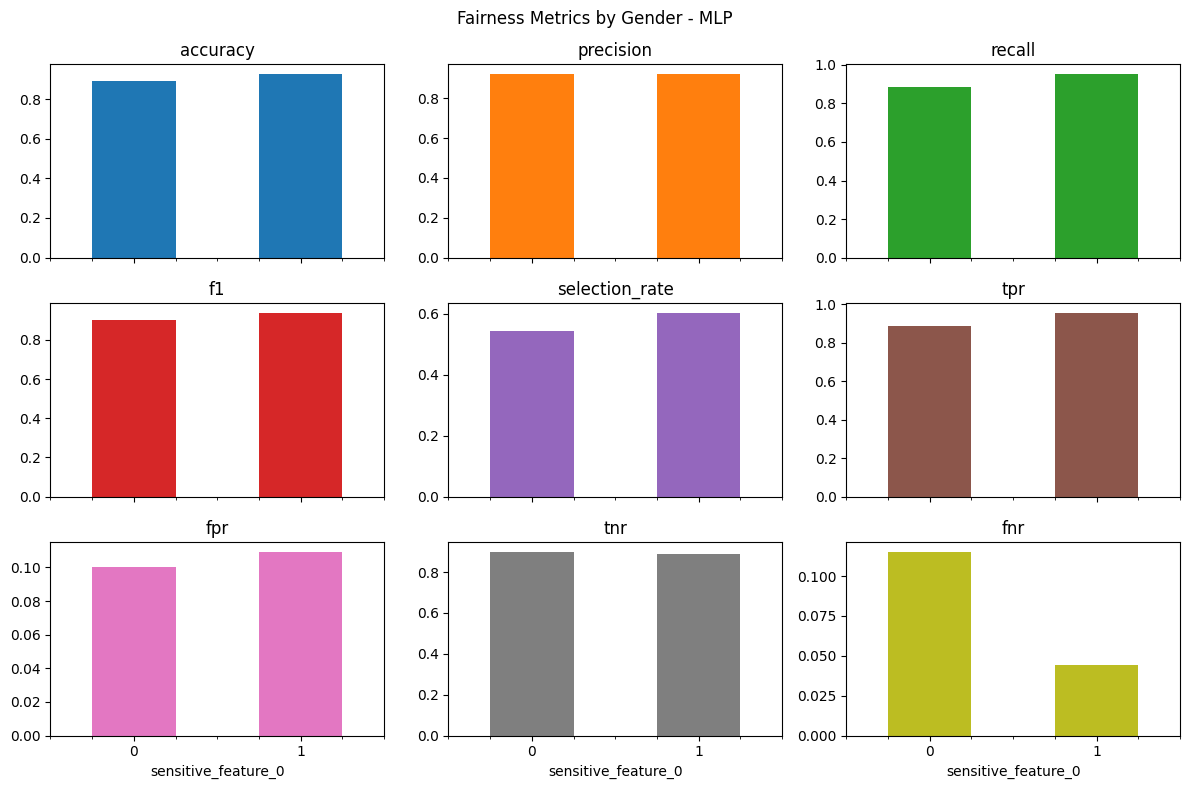


Between-group differences (max group − min group):
accuracy          0.037267
precision         0.004731
recall            0.070940
f1                0.037930
selection_rate    0.060418
tpr               0.070940
fpr               0.009375
tnr               0.009375
fnr               0.070940
dtype: float64

Between-group ratios (min / max):
accuracy          0.959866
precision         0.994884
recall            0.925760
f1                0.959644
selection_rate    0.899953
tpr               0.925760
fpr               0.914286
tnr               0.989583
fnr               0.385185
dtype: float64

Disparate Impact Ratio (selection rate): 0.9000
Equality of Opportunity Difference (TPR gap): 0.0709


In [25]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

## Fairness Metrics by Gender – MLP Model

This section reports the fairness evaluation of the MLP model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.8913   | 0.9200    | 0.8846 | 0.9020 | 0.5435         | 0.8846 | 0.1000 | 0.9000 | 0.1154 |
| Male    | 0.9286   | 0.9247    | 0.9556 | 0.9399 | 0.6039         | 0.9556 | 0.1094 | 0.8906 | 0.0444 |

---

### Between-Group Differences

| Metric           | Difference (max − min) | Ratio (min / max) |
|------------------|-------------------------|-------------------|
| Accuracy         | 0.0373                  | 0.9599            |
| Precision        | 0.0047                  | 0.9949            |
| Recall           | 0.0709                  | 0.9258            |
| F1               | 0.0379                  | 0.9596            |
| Selection Rate   | 0.0604                  | 0.9000            |
| TPR              | 0.0709                  | 0.9258            |
| FPR              | 0.0094                  | 0.9143            |
| TNR              | 0.0094                  | 0.9896            |
| FNR              | 0.0709                  | 0.3852            |

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate)**: **0.9000**  
  - Above the 0.80 threshold, indicating **reasonably balanced selection outcomes**, though males receive more positive predictions.  

- **Equality of Opportunity Difference (TPR gap)**: **0.0709**  
  - Males achieve a higher **true positive rate (95.6%)** compared to females (88.5%).  
  - This gap suggests that males benefit from better sensitivity, while females face a higher chance of missed positives.  

---

### Interpretation

- **Female group (0)**: Lower accuracy and recall, with a higher **false negative rate (11.5%)**, meaning more true cases are missed.  
- **Male group (1)**: Higher recall and F1 score, with fewer missed positives (**FNR = 4.4%**), but slightly higher false positives (10.9% vs. 10.0%).  
- **Fairness Assessment**: While performance is good for both genders, disparities in **recall, TPR, and FNR** indicate a **bias in favor of males**, as they are more reliably identified as positive cases.  

**Overall**: The MLP model achieves **acceptable fairness**, but the higher **true positive rate for males** reveals a gender bias that disadvantages females in correct positive predictions.

---

In [27]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.925962
1                    0.981944

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.108703
1                    0.067509


## Group-Specific Performance – MLP Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9260  | 0.1087      |
| Male    | 0.9819  | 0.0675      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.93** – strong discrimination ability, but notably weaker than for males.  
  - Males: **0.98** – near-perfect discrimination, showing the model distinguishes much better for male cases.  

- **Brier Score**  
  - Females: **0.109** – higher calibration error, meaning predicted probabilities for females are less reliable.  
  - Males: **0.068** – substantially lower error, indicating more accurate probability estimates.  

---

**Overall**: The MLP model shows a **clear gender performance gap**. While both groups perform well, males benefit from **higher discrimination and better probability calibration**, whereas females experience **less reliable predictions**. This imbalance highlights a potential **fairness concern in favor of males**.

---

## Comparison of Results

In [29]:
# Build results dict
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("Mendeley_75M25F_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [30]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [35]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

import pandas as pd

# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.0802,0.1752
DT,0.0387,0.0406
RF,0.0438,0.0688
MLP,0.0604,0.0709


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.8261     0.9091  0.7692  0.8333          0.4783  0.7692   
      1         0.9610     0.9884  0.9444  0.9659          0.5584  0.9444   
DT    0         0.9130     0.9231  0.9231  0.9231          0.5652  0.9231   
      1         0.9026     0.9032  0.9333  0.9180          0.6039  0.9333   
RF    0         0.9565     0.9286  1.0000  0.9630          0.6087  1.0000   
      1         0.9545     0.9770  0.9444  0.9605          0.5649  0.9444   
MLP   0         0.8913     0.9200  0.8846  0.9020          0.5435  0.8846   
      1         0.9286     0.9247  0.9556  0.9399          0.6039  0.9556   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.1000  0.9000  0.2308  
      1       0.0156  0.9844  0.0556  
DT    0       0.1000  0.9000  0.0769  
      1       0.1406  0.8594  0.0667  
RF    0       0.1000  0.9000  0.0000  
      1       0.0312  0.9688  0.0556  
MLP   0       0.1000  0.9000  0.1154  
      1       0.1094  0.8906  0.0444

,Female (0),Male (1)
Model,,
KNN,0.9365,0.9922
DT,0.9058,0.9352
RF,0.9962,0.9858
MLP,0.9260,0.9819


,Female (0),Male (1)
Model,,
KNN,0.1036,0.0380
DT,0.0867,0.0830
RF,0.0407,0.0400
MLP,0.1087,0.0675


## Fairness Evaluation Across Models (Mendeley Dataset)

The following results summarize fairness and performance metrics for four models (KNN, Decision Tree, Random Forest, and MLP) trained on the **Mendeley dataset** with a **gender imbalance (75% male vs. 25% female in the training set)**.

---

### Group Fairness Metrics

| Model | Demographic Parity Difference | Equalized Odds Difference |
|-------|-------------------------------|---------------------------|
| KNN   | 0.0802                        | 0.1752                    |
| DT    | 0.0387                        | 0.0406                    |
| RF    | 0.0438                        | 0.0688                    |
| MLP   | 0.0604                        | 0.0709                    |

- **Decision Tree (DT)** shows the lowest fairness gaps, suggesting **balanced predictions across genders**.  
- **KNN** exhibits the largest disparities, especially in **Equalized Odds Difference (0.1752)**, indicating error rates differ strongly between male and female groups.  
- **Random Forest (RF)** and **MLP** fall in between, with moderate fairness differences.

---

### Group-Specific Classification Metrics

For each model, performance was broken down by gender (0 = Female, 1 = Male).

- **KNN**: Higher accuracy and recall for males, but females suffer from a high **false negative rate (23%)**, meaning many positive cases are missed.  
- **DT**: Balanced results across genders, though males experience a slightly higher **false positive rate (14%)**.  
- **RF**: Females benefit from **perfect recall (TPR = 1.0)** with no false negatives, while males show higher precision but some missed positives.  
- **MLP**: Males consistently outperform females across **accuracy, recall, and F1**, with females facing a **higher false negative rate (11.5%)**.

---

### ROC-AUC and Brier Score by Gender

| Model | ROC-AUC Female | ROC-AUC Male | Brier Female | Brier Male |
|-------|----------------|--------------|--------------|------------|
| KNN   | 0.9365         | 0.9922       | 0.1036       | 0.0380     |
| DT    | 0.9058         | 0.9352       | 0.0867       | 0.0830     |
| RF    | 0.9962         | 0.9858       | 0.0407       | 0.0400     |
| MLP   | 0.9260         | 0.9819       | 0.1087       | 0.0675     |

- **Discrimination (ROC-AUC):**
  - All models show **higher ROC-AUC for males** except Random Forest, which slightly favors females (0.996 vs. 0.986).  
  - The largest gap is seen in **MLP**, where males achieve 0.982 compared to 0.926 for females.  

- **Calibration (Brier Score):**
  - Males generally benefit from lower (better) Brier scores, indicating more reliable probability estimates.  
  - Again, **MLP** shows the largest calibration gap (0.109 for females vs. 0.068 for males).  
  - **RF** is the most balanced with nearly identical Brier scores across genders.

---

### Overall Interpretation

- The **gender imbalance in the training set (75% male vs. 25% female)** likely contributes to the observed disparities, as models often learn better representations for the majority class (males).  
- **Decision Tree** demonstrates the **best fairness balance**, with minimal differences in both demographic parity and equalized odds.  
- **Random Forest** provides excellent predictive performance with balanced calibration but introduces trade-offs: females have no false negatives, but at the cost of higher false positives.  
- **MLP** shows the strongest **bias in favor of males**, with higher discrimination, calibration, and lower error rates for males compared to females.  
- **KNN** struggles with fairness, particularly disadvantaging females with high false negatives and a large Equalized Odds gap.

**Conclusion**: While all models achieve strong performance, fairness evaluation highlights that **male predictions are systematically more accurate and better calibrated**, whereas **female predictions are more error-prone**—a pattern consistent with the male-dominated training data distribution.

---

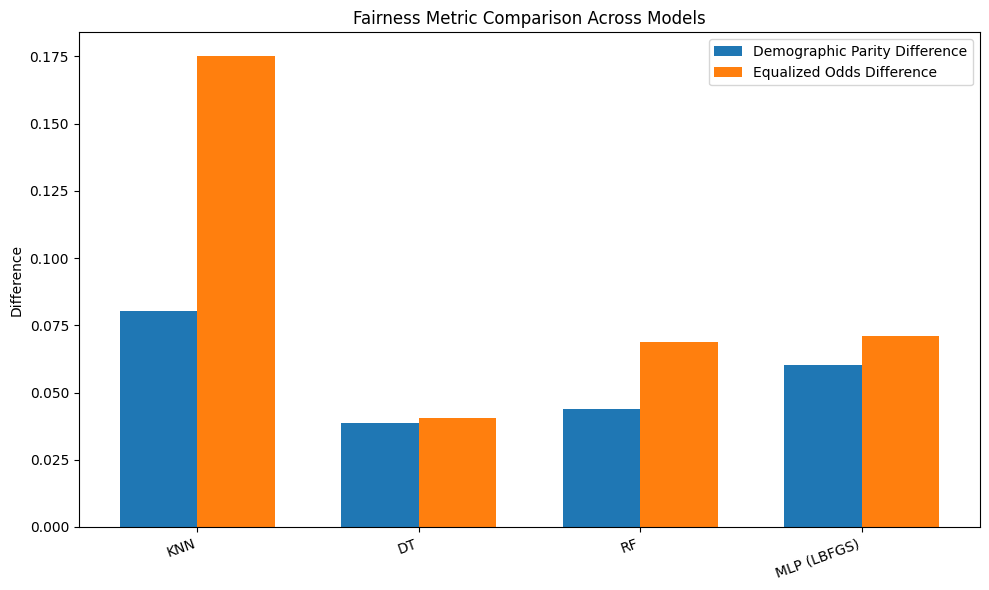

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP (LBFGS)",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

## Fairness Metric Comparison Across Models

The bar chart compares **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** across all models.

- **KNN** shows the largest disparities, particularly in **EOD (~0.175)**, indicating strong error-rate imbalance between genders.  
- **Decision Tree (DT)** achieves the **lowest fairness gaps** (both DPD and EOD < 0.05), suggesting the most balanced predictions.  
- **Random Forest (RF)** and **MLP** lie in between, with moderate disparities but still fairer than KNN.  

**Overall**: Among all models, **DT is the most equitable**, while **KNN is the least fair**, with RF and MLP providing a trade-off between fairness and performance.

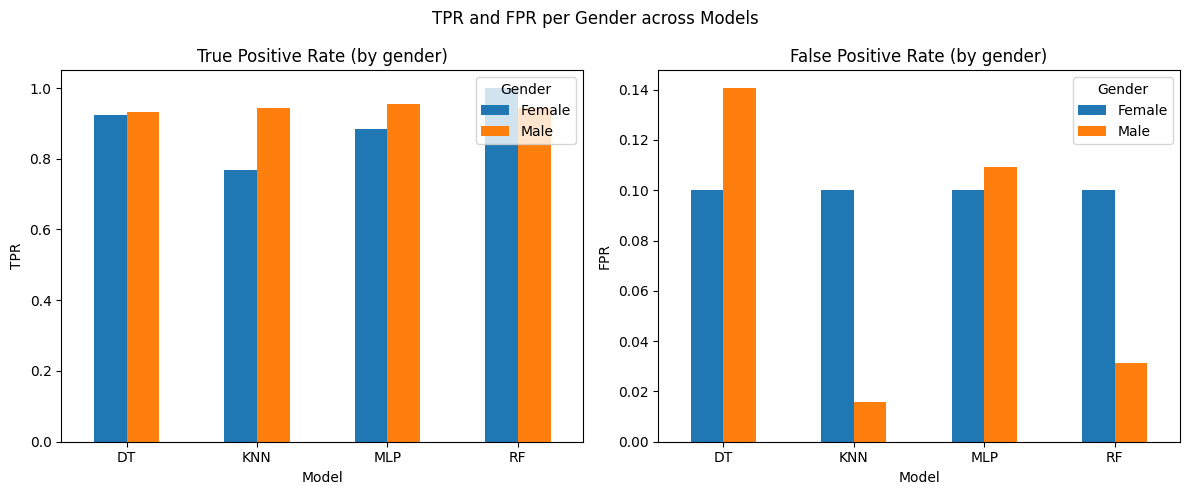

In [37]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

## TPR and FPR per Gender across Models

The plots compare **True Positive Rate (TPR)** and **False Positive Rate (FPR)** for females and males across models.

- **True Positive Rate (TPR):**  
  - Males generally achieve **higher TPRs** than females in KNN and MLP, indicating more correct positive predictions.  
  - Random Forest (RF) strongly favors females with **perfect TPR (1.0)**, while males fall slightly lower.  
  - Decision Tree (DT) shows nearly equal TPRs across genders, reflecting balanced sensitivity.  

- **False Positive Rate (FPR):**  
  - Males show higher FPRs in DT and MLP, meaning more false alarms compared to females.  
  - In KNN and RF, females have higher FPRs, though the gap is small in RF.  
  - RF achieves the lowest male FPR overall (~0.03), showing fewer incorrect positives for males.  

**Overall**:  
- **DT** provides the most **balanced TPR**, but with higher FPR for males.  
- **RF** favors females in recall (TPR) but favors males in precision (low FPR).  
- **KNN and MLP** both show **male advantage in sensitivity (TPR)**, but with different trade-offs in FPR.  


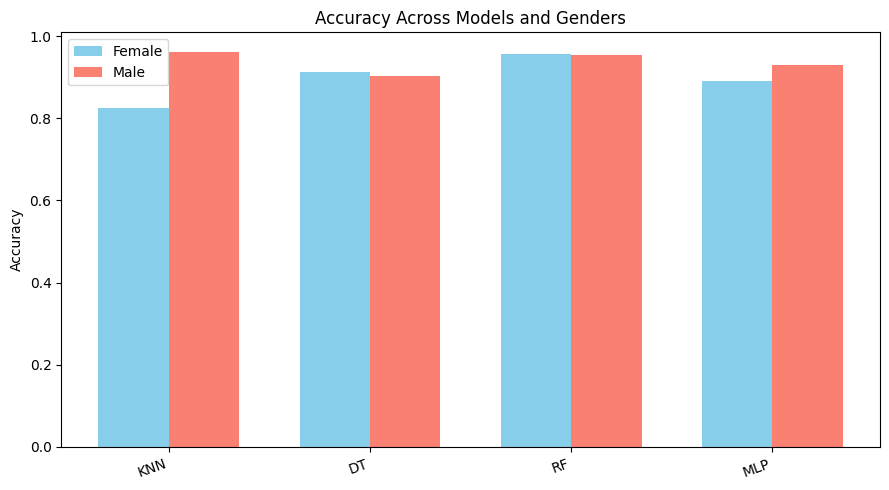

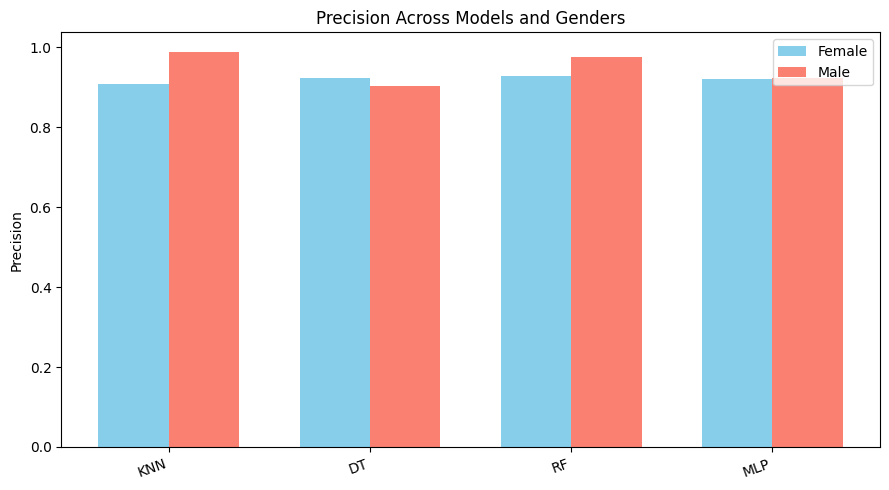

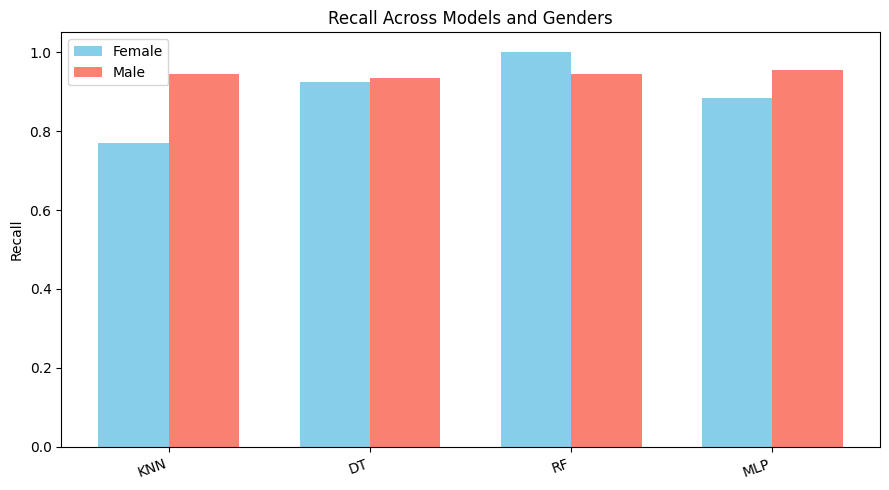

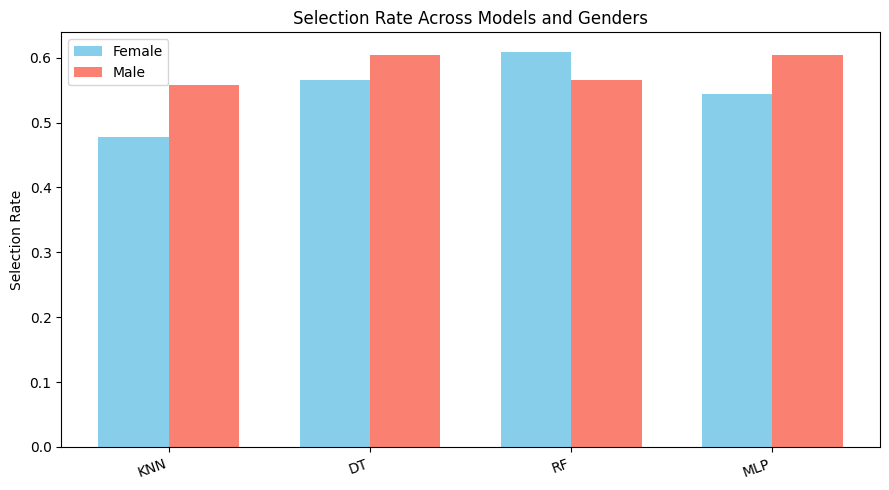

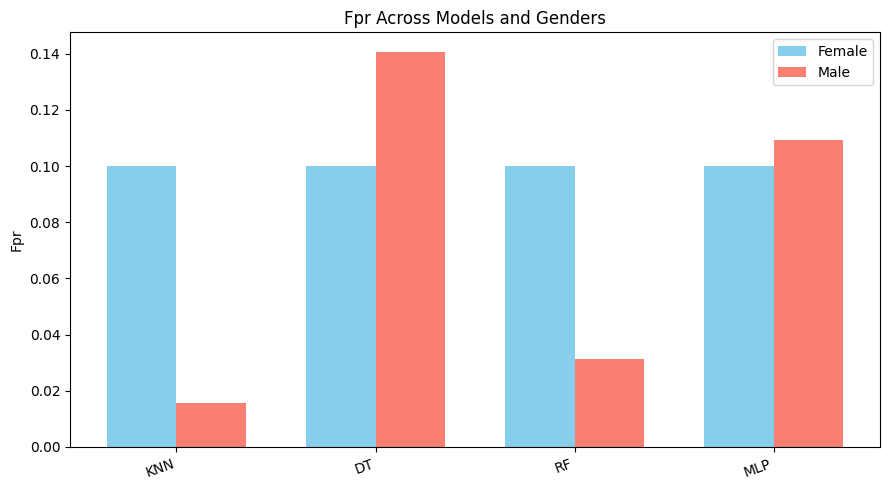

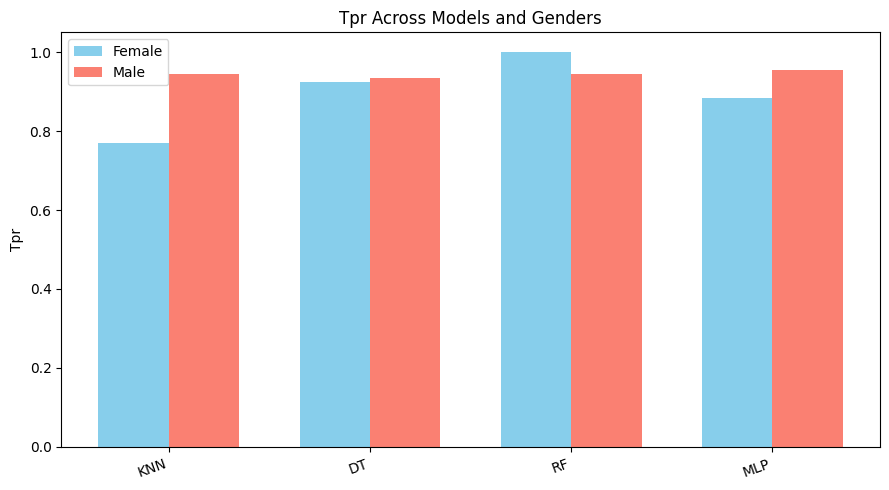

In [38]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Performance and Fairness Metrics Across Models and Genders

The plots show **accuracy, precision, recall, selection rate, FPR, and TPR** for females and males across the four models (KNN, DT, RF, MLP).

### Accuracy
- **KNN**: Clear male advantage, with males achieving much higher accuracy than females.  
- **DT**: Accuracy is almost balanced across genders.  
- **RF**: Very high and nearly equal accuracy for both genders.  
- **MLP**: Males again outperform females slightly.  

### Precision
- **KNN and RF**: Males benefit from notably higher precision, meaning fewer false positives.  
- **DT**: Females have slightly higher precision.  
- **MLP**: Precision is nearly identical across genders.  

### Recall (Sensitivity)
- **KNN**: Strong gender gap, males significantly outperform females.  
- **DT**: Balanced recall between genders.  
- **RF**: Favors females with **perfect recall (1.0)**, while males are slightly lower.  
- **MLP**: Males outperform females, highlighting more missed positives in the female group.  

### Selection Rate
- **KNN, DT, and MLP**: Males receive more positive predictions than females.  
- **RF**: Favors females with a slightly higher selection rate.  

### False Positive Rate (FPR)
- **KNN and RF**: Females have higher FPR, indicating more false alarms.  
- **DT and MLP**: Males show higher FPR, especially in DT (0.14).  

### True Positive Rate (TPR)
- **KNN and MLP**: Males achieve higher TPR, showing better sensitivity.  
- **DT**: Almost equal across genders.  
- **RF**: Favors females with a perfect TPR, while males are slightly lower.  

---

### Overall Interpretation
- **KNN**: Strong male advantage in nearly all metrics, with females facing lower accuracy, recall, and TPR.  
- **DT**: The most **balanced model**, showing small gaps in all metrics.  
- **RF**: Extremely strong performance overall, favoring **females in recall/TPR** but **males in precision/FPR**.  
- **MLP**: Bias toward males, with better accuracy, recall, and TPR, while females face more false negatives.  

**Conclusion**:  
- **DT** achieves the fairest balance.  
- **RF** shows high performance for both genders but introduces trade-offs (female advantage in recall vs. male advantage in precision).  
- **KNN and MLP** both lean strongly toward **male advantage**, disadvantaging females in key fairness-related metrics.
